In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import ast
import warnings

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.base import BaseEstimator, TransformerMixin

Let us first define some classes which we will use for preprocessing of the data

In [2]:
class ColumnDataPreprocessor:

    def preprocess_languages(self, df):
        df['original_language'].apply(lambda x: 'other' if x != 'en' else 'en')


In [3]:
class ColumnSelector():

    def remove_unwanted_columns(self, df, column_to_remove):
        return df.drop(columns=column_to_remove)

    def consider_subset_of_columns(self, df, columns):
        return df[columns]

In [4]:
class DictionaryDataExtractor:

    dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

    def text_to_dict(self, df, dict_columns=dict_columns):
        for column in dict_columns:
            df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
        return df

    def extract_data_from_dict(self, df, column_name, attribute_name):
        return df[column_name].apply(lambda x: x[0][attribute_name] if len(x) > 0 else None)
    
    def extract_release_year(self, df):
        return df['release_date'].apply(lambda x: x.split('/')[2])

    def convert_if_condition_is_met(self, df, column_name, threshold):
        dictionary = dict(df[column_name].value_counts())
        return df[column_name].apply(lambda x: 'other' if self._check_if_number_of_appearances_are_below_threshold(x, threshold, dictionary) else x)


    def _check_if_number_of_appearances_are_below_threshold(self, name, threshold, dictionary):
        for element, number_appearances in dictionary.items():
            if element == name:
                if number_appearances < threshold:
                    return True
                return False
        return False

In [5]:
class DataFrameSelector(BaseEstimator, TransformerMixin):

     def __init__(self, attribute_names):
         self.attribute_names = attribute_names

     def fit(self, X, y=None):
         return self

     def transform(self, X):
         return X[self.attribute_names].values

In [6]:
warnings.filterwarnings('ignore')

dictionary_data_extractor = DictionaryDataExtractor()
column_selector = ColumnSelector()
column_data_preprocessor = ColumnDataPreprocessor()

In [7]:
# include path_to_train and path_to_test with the corresponding csv's
train = pd.read_csv(path_to_train)
test = pd.read_csv(path_to_test)

train = dictionary_data_extractor.text_to_dict(train)
test = dictionary_data_extractor.text_to_dict(test)

Now we can use the classes defined above to prepare the data.

In [8]:
train_without_id = column_selector.remove_unwanted_columns(train, ['id'])

reduced_train_set = column_selector.consider_subset_of_columns(train_without_id, ['budget', 'genres', 'original_language', 'popularity', 'release_date', 'runtime', 'Keywords', 'cast', 'crew','revenue'])

In [9]:
reduced_train_set['cleansed_languages'] = str(column_data_preprocessor.preprocess_languages(reduced_train_set))
reduced_train_set['release_year'] = dictionary_data_extractor.extract_release_year(reduced_train_set)
reduced_train_set['main_genre'] = str(dictionary_data_extractor.extract_data_from_dict(reduced_train_set, 'genres', 'name'))
reduced_train_set['main_actor'] = str(dictionary_data_extractor.extract_data_from_dict(reduced_train_set, 'cast', 'name'))
reduced_train_set['main_actor'] = str(dictionary_data_extractor.convert_if_condition_is_met(reduced_train_set, 'main_actor', 3))
reduced_train_set['main_keyword'] = str(dictionary_data_extractor.extract_data_from_dict(reduced_train_set, 'Keywords', 'name'))
reduced_train_set['main_keyword'] = str(dictionary_data_extractor.convert_if_condition_is_met(reduced_train_set, 'main_keyword', 6))
reduced_train_set['main_crew_member'] = str(dictionary_data_extractor.extract_data_from_dict(reduced_train_set, 'crew', 'name'))
reduced_train_set['main_crew_member'] = str(dictionary_data_extractor.convert_if_condition_is_met(reduced_train_set, 'main_crew_member', 6))

train_after_handling_dicts = column_selector.remove_unwanted_columns(reduced_train_set, ['original_language', 'genres', 'Keywords', 'cast', 'crew'])

In [10]:
train_labels = train_after_handling_dicts['revenue']

In [11]:
cat_attributes = ['cleansed_languages', 'main_genre', 'main_keyword', 'main_actor', 'main_crew_member']
num_attributes = ['budget', 'popularity', 'runtime', 'release_year']

In [12]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(num_attributes)),
    ('impute_age', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('select_categorical', DataFrameSelector(cat_attributes)),
    ('cat_encoder', OneHotEncoder()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [13]:
X_train_prepared = full_pipeline.fit_transform(train_after_handling_dicts)
y_train_prepared = train['revenue']

In [14]:
X_train, X_val, y_train, y_val = \
    train_test_split(X_train_prepared, y_train_prepared.values, test_size=0.1, random_state=42)

Before feeding the data into a randon forest, we first look for a good choice of hyperparameters

In [15]:
param_grid = [
    {'n_estimators': [3, 5, 10], 'max_depth': [5, 10, 15], 'max_features': [3, 6, 9]}
]

In [16]:
random_forest = RandomForestRegressor()
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='neg_mean_squared_log_error')
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 15, 'max_features': 9, 'n_estimators': 3}

Finally, we can evaluate how the model performs and its feature importance

In [17]:
best_forest = grid_search.best_estimator_

feature_importances = best_forest.feature_importances_
all_attributes = cat_attributes + num_attributes
sorted(zip(feature_importances, all_attributes), reverse=True)

[(0.6394563400776371, 'cleansed_languages'),
 (0.18131940951753625, 'main_genre'),
 (0.10810881577423037, 'main_keyword'),
 (0.07111543463059619, 'main_actor'),
 (0.0, 'runtime'),
 (0.0, 'release_year'),
 (0.0, 'popularity'),
 (0.0, 'main_crew_member'),
 (0.0, 'budget')]

In [18]:
best_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3, n_jobs=None, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
class ModelEvaluator:

    def evaluate_model(self, best_forest, input, labels, limit):
        predictions = best_forest.predict(input)
        some_predictions = predictions[:limit]
        some_labels = list(labels)[:limit]

        differences = np.array(some_predictions) - np.array(some_labels)
        relative_errors = differences / np.array(some_labels)
        rmsle = np.sqrt(mean_squared_log_error(list(labels), predictions))

        plt.plot(some_labels, label='true labels', linewidth=2)
        plt.plot(some_predictions, label='predicted labels', linewidth=2)
        plt.show()

        return relative_errors, rmsle

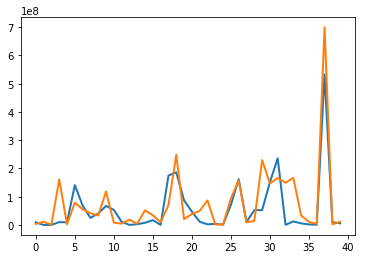

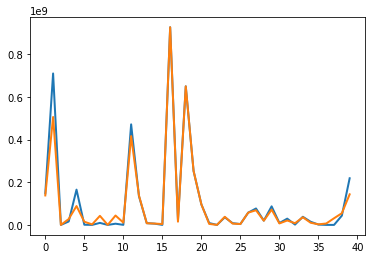

In [20]:
model_evaluator = ModelEvaluator()
relative_validation_errors, rmsle_validation = model_evaluator.evaluate_model(best_forest, X_val, y_val, 40)
relative_train_errors, rmsle_train = model_evaluator.evaluate_model(best_forest, X_train, y_train, 40)

In [21]:
rmsle_validation

2.477254000731655